### Three years with data from three sources

- ecofoci websource: 106697 (2012)
- pavlof erddap server: 136861 (2015)
- akutan erddap server: 122540

1986-2015 Quality Controlled Data is available from https://www.ecofoci.noaa.gov/drifters/efoci_drifterData.shtml

Formats and options change (as do headerlines and meta information) throughout the window of time available.  Usually, all files of a given year are well documented and similar.

In [1]:
import pandas as pd
import numpy as np
from netCDF4 import Dataset

import datetime

In [2]:
from erddapy import ERDDAP

import urllib
try:
    from urllib.parse import unquote
except ImportError:
    from urllib2 import unquote

### Get Data from FOCI online web archive

In [3]:
#data directory
floats = {'106697':'2012'}

In [4]:
data = {}
column_names=['latitude','longitude','year','doy','hhmm','drogue','battery','sst','satqual','ice']

#function to parse dates that are three column information
dateparse = lambda x: pd.datetime.strptime(x, '%Y %j %H%M')

#for i in range(136859,136873,1):
for key,value in floats.items():
    try:
        data.update({key:pd.read_csv('https://www.ecofoci.noaa.gov/drifters/data'+str(value)+'/'+str(key)+'_y'+str(value)+'_withTandIce.asc', 
                    dtype={'hhmm': str, 'year': str, 'doy': str},
                    header=29,
                    names=column_names,
                    delimiter='\s+',
                    parse_dates=[['year','doy','hhmm']],
                    date_parser=dateparse, 
                    index_col='year_doy_hhmm')})
        print('https://www.ecofoci.noaa.gov/drifters/data'+str(value)+'/'+str(key)+'_y'+str(value)+'_withTandIce.asc')
    except:
        print("No data for {i}".format(i=key))

https://www.ecofoci.noaa.gov/drifters/data2012/106697_y2012_withTandIce.asc


In [5]:
data['106697']['doy']=data['106697'].index.dayofyear
data['106697'].head()

,latitude,longitude,drogue,battery,sst,satqual,ice,doy
year_doy_hhmm,,,,,,,,
2012-08-24 13:48:00,71.220,164.194,4,15.4,5.8,2,0.0,237
2012-08-24 14:26:00,71.221,164.197,5,15.4,5.8,3,0.0,237
2012-08-24 14:58:00,71.220,164.175,5,15.4,5.8,2,0.0,237
2012-08-24 15:31:00,71.216,164.175,5,15.4,5.8,3,0.0,237
2012-08-24 16:04:00,71.216,164.177,6,15.4,5.8,2,0.0,237


### Following datasets from ERDDAP server

In [6]:
server_url='http://downdraft.pmel.noaa.gov:8080/erddap'
e = ERDDAP(server=server_url)

df_d = pd.read_csv(e.get_search_url(response='csv', search_for='drifter'))

drifter = df_d['Dataset ID'].values
print(drifter)

['2015_Argos_Drifters_NRT' '2016_Argos_Drifters_NRT'
 '2017_Argos_Drifters_NRT' '2018_Argos_Drifters_NRT'
 '2019_Argos_Drifters_NRT']


In [7]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -360,
    'max_lon': 540,
    'min_lat': 60.0,
    'max_lat': 90.0,
    'min_time': '2015-01-10T00:00:00Z',
    'max_time': '2020-01-10T00:00:00Z'
}

constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

In [8]:
variables_2 = [e.get_var_by_attr(dataset_id=drifterid, long_name=lambda v: v is not None) for drifterid in drifter]

common_variables_2 = set(variables_2[0]).intersection(*variables_2[1:])

common_variables_2.update(['trajectory_id']) 


In [9]:
from requests.exceptions import HTTPError

dfs_2 = {}
for arfloat in drifter:
    print(arfloat)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables_2
        e.dataset_id=arfloat
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dfs_2.update({arfloat: e.to_pandas(
                            index_col='time (UTC)',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except:
        pass

2015_Argos_Drifters_NRT
2016_Argos_Drifters_NRT
2017_Argos_Drifters_NRT
2018_Argos_Drifters_NRT
2019_Argos_Drifters_NRT


In [10]:
dfg = dfs_2['2015_Argos_Drifters_NRT'].groupby(['trajectory_id']).get_group(136861)
dfg2 = dfs_2['2017_Argos_Drifters_NRT'].groupby(['trajectory_id']).get_group(122540)

In [11]:
dfg = dfg['2015-07-22':]
dfg['doy']=dfg.index.dayofyear
dfg2 = dfg2['2017-06-22':]
dfg2['doy']=dfg2.index.dayofyear

### Overview Plot using basemap/cartopy - 

In [12]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import cmocean

In [13]:
### specify primary bulk figure parameters
fontsize = 20
labelsize = 16
#plotstyle = 'seaborn'
#plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3

mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [14]:

def erddap_etopo1():
    """get subset of etopo1 data from erddap"""
    
    urllib.request.urlretrieve("http://coastwatch.pfeg.noaa.gov/erddap/griddap/etopo180.nc?altitude[(65):1:(78.0)][(-180.0):1:(-130)]","data/etopo1_tmp.nc")
    
def etopo1_subset(file='etopo1.nc', region=None):
    """ read in ardemV2 topography/bathymetry. """
    
    bathydata = Dataset(file)
    
    topoin = bathydata.variables['altitude'][:]
    lons = bathydata.variables['longitude'][:]
    lats = bathydata.variables['latitude'][:]
    bathydata.close()
    
    return(topoin, lats, lons)


In [15]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(11,8.5),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True,linestyle='--',color='lightgrey')
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True,linestyle='--',color='lightgrey')
        gl.xlabels_top = gl.ylabels_right = False
        ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
        ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

    return fig, ax


In [16]:
### Get Bathymetry data from Erddap
#erddap_etopo1()

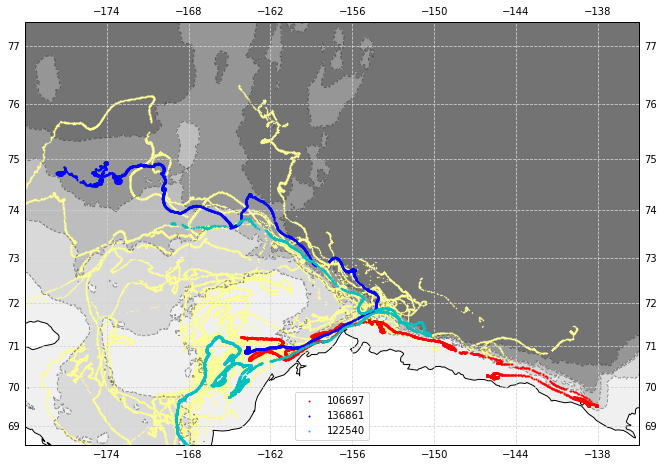

In [17]:
projection=ccrs.Mercator()
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

extent = [-180, -135, 68.5, 76.5]

erddap_etopo1()
(topoin, lats, lons) = etopo1_subset(file='data/etopo1_tmp.nc')

fig,ax = make_map(projection=projection)

for float_yy in dfs_2.keys():
    dfsg = dfs_2[float_yy].groupby(['trajectory_id'])
    for argofloat in dfsg.groups:
        ax.scatter(dfs_2[float_yy].groupby(['trajectory_id']).get_group(argofloat)['longitude (degrees_east)'],
                   dfs_2[float_yy].groupby(['trajectory_id']).get_group(argofloat)['latitude (degrees_north)'],
                   s=0.1, c='#FFFF99',zorder=2,transform=transformation, label='')
    
ax.scatter(data['106697']['longitude']*-1, data['106697']['latitude'], s=1,
           c='r',zorder=3,transform=transformation,label='106697')

"""
for i in range(0,366,14):
    ax.scatter(data['106697'][data['106697']['doy'] == i].head(1)['longitude']*-1,
               data['106697'][data['106697']['doy'] == i].head(1)['latitude'], 
               s=10,
               c='k', marker='+',zorder=3, transform=transformation, label='')
    timetemp = data['106697'][data['106697']['doy'] == i]
    if not (timetemp.empty):
        ax.text(data['106697'][data['106697']['doy'] == i].head(1)['longitude']*-1,
                data['106697'][data['106697']['doy'] == i].head(1)['latitude'], 
                "-".join([str(timetemp.index[0].year),str(timetemp.index[0].month),str(timetemp.index[0].day)]),
                fontsize=8, transform=ccrs.Geodetic())
"""
#--
ax.scatter(dfg['longitude (degrees_east)'], 
           dfg['latitude (degrees_north)'], s=1,
           c='b',zorder=3,transform=transformation,label='136861')
"""
for i in range(0,366,14):
    ax.scatter(dfg[dfg['doy'] == i].head(1)['longitude (degrees_east)'],
               dfg[dfg['doy'] == i].head(1)['latitude (degrees_north)'], 
               s=10,
               c='k', marker='+',zorder=3, transform=transformation, label='')
    timetemp = dfg[dfg['doy'] == i]
    if not (timetemp.empty):
        ax.text(dfg[dfg['doy'] == i].head(1)['longitude (degrees_east)'],
                dfg[dfg['doy'] == i].head(1)['latitude (degrees_north)'], 
                "-".join([str(timetemp.index[0].year),str(timetemp.index[0].month),str(timetemp.index[0].day)]),
                fontsize=8, transform=ccrs.Geodetic())
        
"""
#--
ax.scatter(dfg2['longitude (degrees_east)'], 
           dfg2['latitude (degrees_north)'], s=1,
           c='c',zorder=3,transform=transformation,label='122540')

"""
for i in range(0,366,14):
    ax.scatter(dfg2[dfg2['doy'] == i].head(1)['longitude (degrees_east)'],
               dfg2[dfg2['doy'] == i].head(1)['latitude (degrees_north)'], 
               s=10,
               c='k', marker='+',zorder=3, transform=transformation, label='')
    timetemp = dfg2[dfg2['doy'] == i]
    if not (timetemp.empty):
        ax.text(dfg2[dfg2['doy'] == i].head(1)['longitude (degrees_east)'],
                dfg2[dfg2['doy'] == i].head(1)['latitude (degrees_north)'], 
                "-".join([str(timetemp.index[0].year),str(timetemp.index[0].month),str(timetemp.index[0].day)]),
                fontsize=8, transform=ccrs.Geodetic())
        
"""       
leg = ax.legend(loc='lower center')

## bathymetry contours
CS = plt.contour(lons, lats, topoin, [-1000, -200, -100, -50,], 
                 colors='k', alpha=0.4, linewidths=1, zorder=2,
                 transform=transformation)
CS = plt.contourf(lons, lats, topoin, [-1000, -200, -100, -50,], 
                 colors=('#737373','#969696','#bdbdbd','#d9d9d9','#f0f0f0'), extend='both', zorder=1,
                 transform=transformation)

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)



In [47]:
fig.savefig('3ArcticDrifters_ShelfFlow.png',dpi=300)
fig.savefig('3ArcticDrifters_ShelfFlow.pdf')

128951_y2013_cut.asc
139914_cut_check.y2018
128955_y2013_cut.asc
122542_y2017.vecdis
122534_y2013_cut.asc
136864_y2015_cut.asc
136860_y2015_short.asc
ld119594a_edited_y2012_cut.vecdis
ld111967a_edited_y2012_cut.vecdis
136859_y2015_cut.asc
128952_y2013_cut.asc
122540_y2013_cut.asc
122540_y2013_cut.asc
139913_cut_check.y2018
ld119598a_edited_y2012_cut.vecdis
136872_cut.y2016
136861_y2015_short.asc
136861_y2015_short.asc
ld119595a_edited_y2012_cut.vecdis
122539_y2013_cut.asc
136869_y2015_short.asc
139915_cut_check.y2018
136870_y2015_short.asc
ld119600a_edited_y2012_cut.vecdis
ld106696a_edited_y2012_cut.vecdis
ld111968a_edited_y2012_cut.vecdis
122538_y2013_cut.asc
136868_cut.y2017
136868_y2015_cut.asc
ld119597a_edited_y2012_cut.vecdis
119593_y2012_short.vecdis
139912_cut_gapb.y2018
139912_cut_gap.y2018
ld119599_edited_y2012_cut.vecdis
ld106698_edited_y2011_cutshaun.vecdis
ld106699a_edited_y2011_cut.vecdis
122537_y2017.vecdis
136865_y2015_cut.asc
122535_y2013_cut.asc
122541_y2013_cut.asc
ld

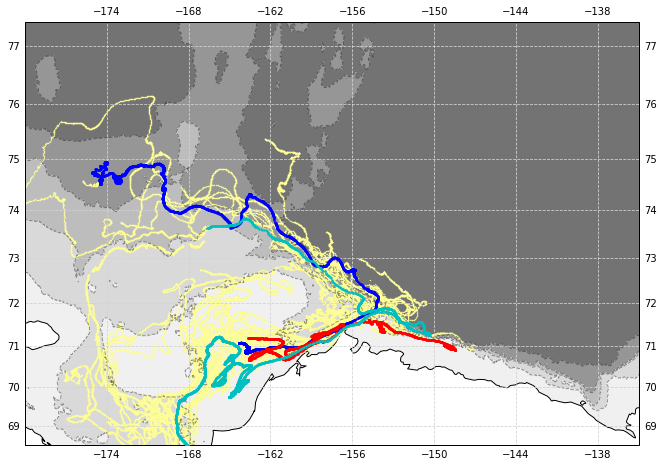

In [16]:
#generate same plot as above, not from erddap though as pjs cleaned raw files :|
import os

projection=ccrs.Mercator()
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

extent = [-180, -135, 68.5, 76.5]

erddap_etopo1()
(topoin, lats, lons) = etopo1_subset(file='data/etopo1_tmp.nc')

fig,ax = make_map(projection=projection)

cpath = '/Users/bell/in_and_outbox/2019/stabeno/drifter_cleanup/cut_good_data/'
for files in os.listdir(cpath):
    if ('.asc' in files) or ('.y2018' in files) or ('.y2017' in files) or ('.y2016' in files):
        print(files)

        
        df_cut = pd.read_csv(cpath+files,header=None,delimiter='\s+')
        ax.scatter((df_cut[1]*-1)+360,df_cut[0],
                   s=0.1, c='#FFFF99',zorder=2,transform=transformation, label='')
    elif ('.vecdis' in files):
        print(files)

        df_cut = pd.read_csv(cpath+files,header=None,skiprows=2,delimiter='\s+')
        ax.scatter((df_cut[4]*-1)+360,df_cut[3],
                   s=0.1, c='#FFFF99',zorder=2,transform=transformation, label='')

        
    if '106697' in files:
        print(files)

        df_cut = pd.read_csv(cpath+files,header=None,skiprows=2,delimiter='\s+')
        ax.scatter((df_cut[4]*-1)+360,df_cut[3],
                   s=2, c='r',zorder=3,transform=transformation,label='106697')
    elif '136861' in files:
        print(files)

        df_cut = pd.read_csv(cpath+files,header=None,delimiter='\s+')
        ax.scatter((df_cut[1]*-1)+360,df_cut[0],
                   s=2, c='b',zorder=3,transform=transformation,label='136861')
    elif '122540' in files:
        print(files)

        df_cut = pd.read_csv(cpath+files,header=None,skiprows=2,delimiter='\s+')
        ax.scatter((df_cut[4]*-1)+360,df_cut[3],
                   s=2, c='c',zorder=3,transform=transformation,label='122540')
                                             
#leg = ax.legend(loc='lower center')

## bathymetry contours
CS = plt.contour(lons, lats, topoin, [-1000, -200, -100, -50,], 
                 colors='k', alpha=0.4, linewidths=1, zorder=2,
                 transform=transformation)
CS = plt.contourf(lons, lats, topoin, [-1000, -200, -100, -50,], 
                 colors=('#737373','#969696','#bdbdbd','#d9d9d9','#f0f0f0'), extend='both', zorder=1,
                 transform=transformation)

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)



In [20]:
fig.savefig('3ArcticDrifters_ShelfFlow.clean.png',dpi=300)
fig.savefig('3ArcticDrifters_ShelfFlow.clean.pdf')

ld106698_edited_y2011_cut.vecdis


/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


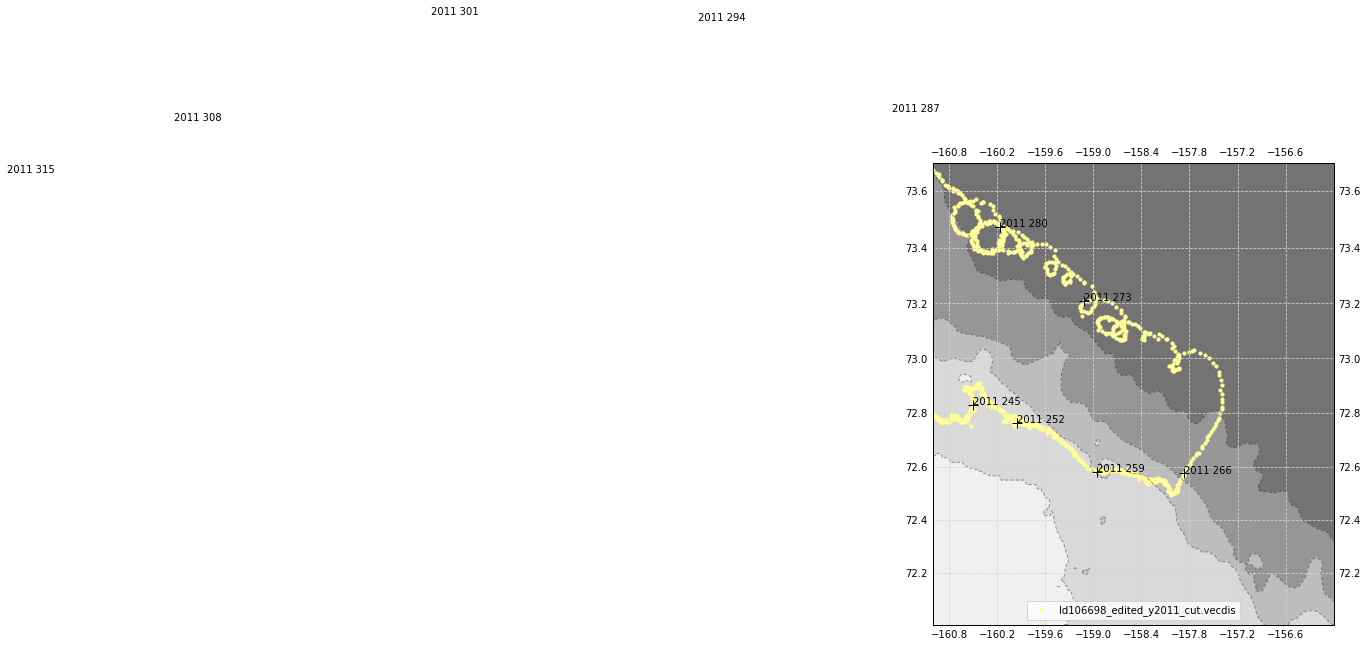

In [98]:
#generate same plot as above, not from erddap though as pjs cleaned raw files :|
import os

cpath = '/Users/bell/in_and_outbox/2019/stabeno/drifter_cleanup/cut_good_data/'
for files in os.listdir(cpath):
    
    if files in ['ld106698_edited_y2011_cut.vecdis']:
        projection=ccrs.Mercator()
        transformation=ccrs.PlateCarree()

        land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='face',
                                                facecolor='1.0')

        extent = [-161, -156, 72., 73.7]

        erddap_etopo1()
        (topoin, lats, lons) = etopo1_subset(file='data/etopo1_tmp.nc')

        fig,ax = make_map(projection=projection)


        if ('.asc' in files) or ('.y2018' in files) or ('.y2017' in files) or ('.y2016' in files):
            print(files)


            df_cut = pd.read_csv(cpath+files,header=None,delimiter='\s+')
            ax.scatter((df_cut[1]*-1)+360,df_cut[0],
                       s=10, c='#FFFF99',zorder=2,transform=transformation, label=files)
        elif ('.vecdis' in files):
            print(files)

            df_cut = pd.read_csv(cpath+files,header=None,skiprows=2,delimiter='\s+')
            ax.scatter((df_cut[4]*-1)+360,df_cut[3],
                       s=10, c='#FFFF99',zorder=2,transform=transformation, label=files)
            df_weekly = df_cut[df_cut[2] == 2400][df_cut[1] % 7 == 0]
            ax.plot((df_weekly[4]*-1)+360,df_weekly[3],'k+',markersize=10,transform=transformation, label='')
            for i,j in df_weekly.iterrows():
                ax.text((j[4]*-1)+360,j[3],str(int(j[0]))+' '+str(int(j[1])),transform=transformation)



        leg = ax.legend(loc='lower center')

        ## bathymetry contours
        CS = plt.contour(lons, lats, topoin, [-1000, -200, -100, -50,], 
                         colors='k', alpha=0.4, linewidths=1, zorder=2,
                         transform=transformation)
        CS = plt.contourf(lons, lats, topoin, [-1000, -200, -100, -50,], 
                         colors=('#737373','#969696','#bdbdbd','#d9d9d9','#f0f0f0'), extend='both', zorder=1,
                         transform=transformation)

        ax.add_feature(land_50m)
        ax.coastlines(resolution='50m')
        ax.set_extent(extent)

        fig.savefig('3ArcticDrifters_ShelfFlow.'+files+'.png',dpi=300)


